In [1]:
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None 

### XG BOOST CLASS CREATION

-----


In [2]:
class Xg_boost():

    """Apply a Xg Boost model and calculate the importance of predictor variables for the model.
    """

    def __init__(self, dataframe, response_variable):

        """Constructor method.
        Parameters: Dataframe for application of model, response variable.
        """

        self.dataframe = dataframe
        self.response_variable = response_variable


    def fit_model(self, n_estimators= 100, max_depth= 5, reg_alpha= 0.1, reg_lambda= 1):

        """Fits a decission tree model on the given dataset, dividing it into separate training and testing sets.
        Parameters: Parameters we choose for the method. If no parameters are passed, default parameters will be used.
        Returns: Model object.
        """

        X = self.dataframe.drop(self.response_variable, axis = 1)
        y = self.dataframe[self.response_variable]

        X = X.apply(lambda col: col.cat.codes if col.dtype.name == 'category' else col)

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

        self.xg_boost_reg = XGBRegressor(
                            n_estimators = n_estimators,
                            max_depth = max_depth,
                            reg_alpha = reg_alpha,
                            reg_lambda = reg_lambda)

        self.xg_boost_reg.fit(self.x_train, self.y_train)

        self.y_pred_test = self.xg_boost_reg.predict(self.x_test)
        self.y_pred_train = self.xg_boost_reg.predict(self.x_train)

        self.y_pred_test = np.round(self.y_pred_test)
        self.y_pred_train = np.round(self.y_pred_train)

        return self.xg_boost_reg

    def get_metrics(self, model_name):

        """Create a dataframe showing the model's metrics, divided between the train and test sets.
        Parameters: Name of the method we are going to use.
        Returns: Dataframe containing model metrics.
        """
        
        accuracy_test = accuracy_score(self.y_test, self.y_pred_test)
        precision_test = precision_score(self.y_test, self.y_pred_test)
        recall_test = recall_score(self.y_test, self.y_pred_test)
        f1_test = f1_score(self.y_test, self.y_pred_test)
        kappa_test = cohen_kappa_score(self.y_test, self.y_pred_test)

        accuracy_train = accuracy_score(self.y_train, self.y_pred_train)
        precision_train = precision_score(self.y_train, self.y_pred_train)
        recall_train = recall_score(self.y_train, self.y_pred_train)
        f1_train = f1_score(self.y_train, self.y_pred_train)
        kappa_train = cohen_kappa_score(self.y_train, self.y_pred_train)
            
        dataframe = pd.DataFrame({'accuracy': [accuracy_test, accuracy_train], 
                            'precision': [precision_test, precision_train],
                            'recall': [recall_test, recall_train], 
                            'f1': [f1_test, f1_train],
                            'kappa': [kappa_test, kappa_train],
                            'set': ['test', 'train']})
        
        dataframe['model'] = model_name

        return dataframe
    
    
    def create_df_feature_importance(self):

        """Create a dataframe showing the importance of the features for the model.
        Parameters: None
        Returns: Dataframe containing model the importance of the features.
        """

        self.predictors_sig_dataframe = pd.DataFrame({'predictor': self.x_train.columns, 'importance': self.xg_boost_reg.feature_importances_})

        self.predictors_sig_dataframe.sort_values(by=['importance'], ascending=False, inplace = True)

        return self.predictors_sig_dataframe
        

    def create_barplot_feature_importance(self, title_dataframe):

        """Create a barplot showing the importance of the features for the model.
        Parameters: Title of the dataframe we are using.
        Returns: None
        """

        my_barplot_palette = LinearSegmentedColormap.from_list('Gradient', ['teal', 'mediumturquoise', 'paleturquoise'])
        num_bars = (len(self.dataframe.columns) -1)

        plt.figure(figsize=(10,6))
        sns.barplot(x = 'importance', y = 'predictor', data = self.predictors_sig_dataframe, palette= my_barplot_palette(np.linspace(0, 1, num_bars)))
        plt.title(f'{title_dataframe.upper()} XG BOOST FEATURE IMPORTANCE', fontsize = 12, color = 'darkslategray', fontweight = 'bold')
        plt.show()

### XG BOOST ON RANDOM_OVER_SAMPLE DATAFRAME

-----


In [3]:
df_over = pd.read_pickle('../data/generated_data/cardio_processed_over.pkl')
df_over.head()

,age_category,BMI_category,BPMeds,prevalentStroke,prevalentHyp,diabetes,age,cigsPerDay,totChol,sysBP,BMI,heartRate,glucose,education_1.0,education_2.0,education_3.0,education_4.0,sex_F,sex_M,is_smoking_NO,is_smoking_YES,TenYearCHD
0,2.0,0.25,0,0,0,0,1.071429,0.15,-0.224138,0.722222,0.450931,1.000000,0.142857,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1
1,0.5,0.25,0,0,1,0,-0.928571,0.00,-0.379310,1.462963,0.883744,-0.200000,-0.214286,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0
2,0.5,0.00,0,0,0,0,-0.214286,0.50,0.275862,-0.462963,-1.012582,0.866667,1.142857,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
3,0.5,0.25,0,0,1,0,0.071429,1.00,-0.017241,1.092593,0.579768,-0.466667,1.142857,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1
4,2.0,0.25,0,0,0,0,1.071429,1.50,0.120690,0.296296,0.209361,-0.333333,-0.071429,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0


In [4]:
response_var = 'TenYearCHD'

In [5]:
xg_boost_over = Xg_boost(df_over, response_var)

In [6]:
xg_boost_pred = xg_boost_over.fit_model(70, 8, 1, 0.8)

In [7]:
with open ('../data/predict_objects/xg_boost_pred.pkl','wb') as g:
    pickle.dump(xg_boost_pred, g)

In [8]:
xgb_over_results = xg_boost_over.get_metrics('OVER Xg Boost')
xgb_over_results

,accuracy,precision,recall,f1,kappa,set,model
0,0.934028,0.88806,0.989311,0.935955,0.868343,test,OVER Xg Boost
1,0.999752,1.00000,0.999509,0.999754,0.999504,train,OVER Xg Boost


In [9]:
xg_boost_over.create_df_feature_importance()

,predictor,importance
17,sex_F,0.155519
6,age,0.102565
9,sysBP,0.067896
7,cigsPerDay,0.065043
14,education_2.0,0.064849
12,glucose,0.059995
10,BMI,0.059671
11,heartRate,0.056958
3,prevalentStroke,0.054522
8,totChol,0.053824


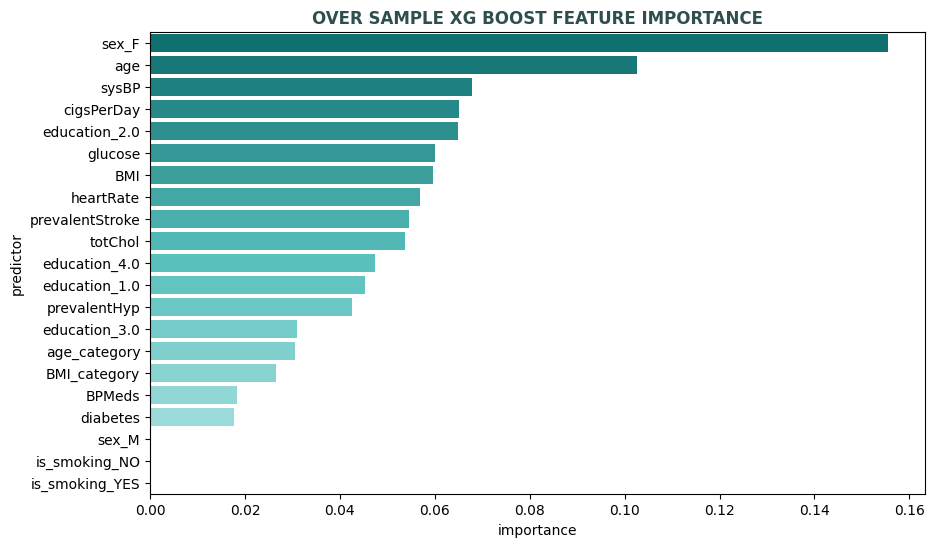

In [10]:
xg_boost_over.create_barplot_feature_importance('over sample')

###  XG BOOST  ON TOKEN_SMOTE DATAFRAME

-----


In [11]:
df_ts = pd.read_pickle('../data/generated_data/cardio_processed_ts.pkl')
df_ts.head()

,age_category,BMI_category,BPMeds,prevalentStroke,prevalentHyp,diabetes,age,cigsPerDay,totChol,sysBP,BMI,heartRate,glucose,TenYearCHD,education_1.0,education_2.0,education_3.0,education_4.0,sex_F,sex_M,is_smoking_NO,is_smoking_YES
0,2.0,0.25,0,0,0,0,1.071429,0.15,-0.224138,0.722222,0.450931,1.000000,0.142857,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.5,0.25,0,0,1,0,-0.928571,0.00,-0.379310,1.462963,0.883744,-0.200000,-0.214286,0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.5,0.00,0,0,0,0,-0.214286,0.50,0.275862,-0.462963,-1.012582,0.866667,1.142857,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.5,0.25,0,0,1,0,0.071429,1.00,-0.017241,1.092593,0.579768,-0.466667,1.142857,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,2.0,0.25,0,0,0,0,1.071429,1.50,0.120690,0.296296,0.209361,-0.333333,-0.071429,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [12]:
xg_boost_ts = Xg_boost(df_ts, response_var)

In [13]:
xg_boost_ts.fit_model()

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
xgb_ts_results = xg_boost_ts.get_metrics('TS Xg Boost')
xgb_ts_results

,accuracy,precision,recall,f1,kappa,set,model
0,0.822026,0.318182,0.187919,0.236287,0.143051,test,TS Xg Boost
1,0.986094,1.000000,0.908840,0.952243,0.944127,train,TS Xg Boost


In [15]:
xg_boost_ts.create_df_feature_importance()

,predictor,importance
14,education_2.0,0.081741
3,prevalentStroke,0.080843
17,sex_F,0.076550
16,education_4.0,0.069680
7,cigsPerDay,0.067409
6,age,0.066499
0,age_category,0.060894
12,glucose,0.059127
9,sysBP,0.053633
13,education_1.0,0.051236


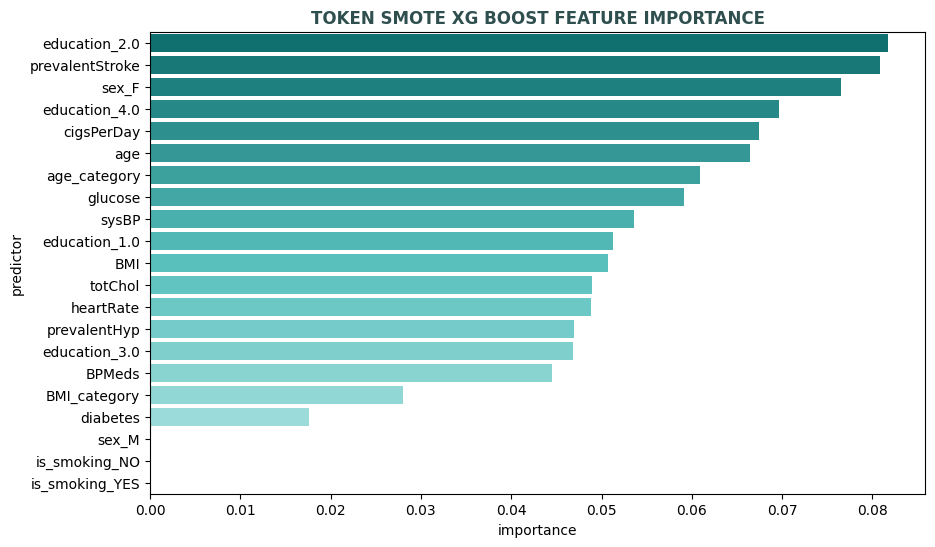

In [16]:
xg_boost_ts.create_barplot_feature_importance('token smote')

### SAVE RESULTS

-----

In [17]:
lr_dt_rf_results = pd.read_pickle('../data/generated_data/LR_DT_RF_results.pkl')

In [18]:
all_results = pd.concat([lr_dt_rf_results, xgb_over_results, xgb_ts_results], axis = 0)
all_results

,accuracy,precision,recall,f1,kappa,set,model
0,0.696181,0.686690,0.692399,0.689533,0.392092,test,OVER Logistic Regression
1,0.676427,0.673614,0.698085,0.685632,0.352517,train,OVER Logistic Regression
0,0.860374,0.684211,0.087248,0.154762,0.125791,test,TS Logistic Regression
1,0.856300,0.744186,0.088398,0.158025,0.129837,train,TS Logistic Regression
0,0.718750,0.690171,0.767221,0.726659,0.438691,test,OVER Decision Tree Best
1,0.763772,0.742729,0.814924,0.777154,0.526980,train,OVER Decision Tree Best
0,0.852507,0.473684,0.060403,0.107143,0.076540,test,TS Decision Tree Best
1,0.853772,0.631579,0.099448,0.171838,0.135976,train,TS Decision Tree Best
0,0.786458,0.757906,0.825416,0.790222,0.573583,test,OVER Random Forest
1,0.828784,0.812819,0.859107,0.835322,0.657312,train,OVER Random Forest


We have achieved outstanding metrics in the Over_Sample Dataframe using this approach. However, overfitting remains unresolved. Regarding the Token_Smote Dataframe, our test metrics are still inadequate.

All our models perform significantly better on balanced dataframes when using the Random Over Sampler method compared to the TokenSMOTE method.

The XGBoost model achieved superior metrics on the test set; however, we have been unsuccessful in correcting the overfitting that occurs. Acceptable metrics were also obtained with the Random Forest model. Consequently, we will employ both models for our predictions and compare the results obtained by each.

In [19]:
all_results.to_pickle('../data/generated_data/ALL_results.pkl')